In [1]:
import numpy as np
import matplotlib.pyplot as plt
import get_input as inp

from set_simulation import compute_g2
from focal_spot_pattern import create_gaussian_mask

from scipy.ndimage import gaussian_filter

## Full code - Trost's thesis

#### General functions

In [2]:
def create_slit_pattern_rand_smooth(X, Y, period, angle, dx_source=0):
    # Rotate the coordinates
    angle = np.deg2rad(angle)
    
    X_rot = X * np.cos(angle) + Y * np.sin(angle)

    mask = np.ones_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (X_rot[i, j] % period) < period / 2:
                mask[i, j] = 1
            else:
                mask[i, j] = -1
    return mask

In [3]:
def rebin_2d(a, bin_factor):
    nrows = (a.shape[0] // bin_factor) * bin_factor
    ncols = (a.shape[1] // bin_factor) * bin_factor
    a_cropped = a[:nrows, :ncols]
    new_shape = (nrows // bin_factor, bin_factor, ncols // bin_factor, bin_factor)
    return a_cropped.reshape(new_shape).sum(axis=(1, 3))

def CCD_detection_binned(intensity, bin_factor, gain=10, QE=0.57, ADC_bits=18):
    """
    Simulate CCD detection by combining binning and photon statistics.
    
    Parameters:
      intensity : 2D array of continuous simulated intensity (e.g., |E|^2).
      bin_factor: Integer number of simulation pixels to combine into one CCD pixel.
      gain      : Gain factor (default: 1).
      QE        : Quantum efficiency (default: 0.57, i.e. 57%).
      ADC_bits  : ADC resolution in bits (default: 10 bits, so max value = 2^10).
      
    Returns:
      detected  : 2D array of simulated CCD counts (integers) after binning and Poisson noise.
    """
    # First, rebin the high-resolution intensity image to the detector pixel scale.
    binned_intensity = rebin_2d(intensity, bin_factor)

    # Now, simulate photon detection using Poisson noise.
    # Here the binned intensity is assumed to represent the mean number of photons per CCD pixel.
    detected = np.random.poisson(binned_intensity) * gain * QE

    # Clip values that exceed the ADC maximum
    max_value = 2 ** ADC_bits
    detected[detected > max_value] = max_value
    
    # Round to nearest integer (simulate ADC digitization)
    detected = np.round(detected).astype(int)
    
    return detected

#### Setup

In [4]:
# initializing variables
setup = inp.Config('inp_files/setup.inp')
setup.padding_factor = int(setup.padding_factor)

In [5]:
dx_source = setup.grid_size/setup.num_pixels
x_det_sim = np.fft.fftshift(np.fft.fftfreq(setup.num_pixels * (1 + setup.padding_factor-1//2), d=dx_source))*setup.wavelength*setup.z_prop
dx_det_sim = x_det_sim[1]-x_det_sim[0]
#print(dx_source)
print(dx_det_sim)
#dx_det_sim = dx_source #(setup.wavelength*setup.z_prop)/(setup.num_pixels*dx_source)
bin_factor = int(round(setup.detector_pixel_size/dx_det_sim))

#auxiliary variables
source_size=dx_source*setup.num_pixels
x_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
y_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
X_source, Y_source = np.meshgrid(x_source, y_source)

print(dx_source)

2.530000000000042e-08
2.5e-06


In [6]:
# checking for sampling conditions and Fresnel number
print("Checking for Fresnel number...")
print(f"N_f = {setup.gauss_width**2/(setup.wavelength*setup.z_prop)}\n")

print("Sampling conditions?")
print(bool(2*np.abs(x_source[1]-x_source[0]) >= setup.wavelength*setup.z_prop/source_size))

Checking for Fresnel number...
N_f = 582.3398050065875

Sampling conditions?
True


#### Initial beam

In [7]:
gaussian_mask1 = create_gaussian_mask(X_source, Y_source, w=setup.gauss_width)
extent = [x_source[0], x_source[-1], y_source[0], y_source[-1]]
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, setup.stripe_period, angle=73, dx_source=dx_source)
object_mask1 = gaussian_mask1 * grating_mask1

current_object_mask_func = create_slit_pattern_rand_smooth

#### Propagation function

In [8]:
def fresnel_propagation(E, wavelength, z, dx, padding_factor=1):
    """
    Propagate an input field E using the Fresnel approximation.
    """
    N = E.shape[0]

    pad_width = N * (padding_factor-1)//2

    padded_E = np.pad(E, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
    padded_N = padded_E.shape[0]

    fx = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    FX, FY = np.meshgrid(fx, fy)

    k = 2 * np.pi / wavelength

    H = np.exp(-1j*k*z)*np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))

    input_spectrum = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_E)))

    output_spectrum = input_spectrum * H

    x_det = fx * wavelength * z
    y_det = fy * wavelength * z

    #output_field = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(output_spectrum)))

    return output_spectrum, x_det, y_det

In [9]:
def simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                              gauss_width, stripe_period,
                              current_object_mask_func,
                              num_pixels, dx_source, angle, wavelength,
                              bin_factor, gain, QE, ADC_bits, padding_factor, incoherent=False):
    """
    Simulate intensity images from a multi-shot experiment.
    
    Parameters:
      X_source, Y_source: 2D coordinate grids in the source plane (m)
      num_shots: number of shots (different grating masks)
      num_modes_per_shot: number of modes per shot (random phase realizations)
      I0: source intensity (photons per pixel at source)
      z_prop: propagation distance (m)
      gauss_width: diameter (or width) of the Gaussian aperture (m)
      stripe_period: period of the grating (m)
      current_object_mask_func: function to generate a grating mask;
          Called as: current_object_mask_func(X, Y, period, duty_cycle, angle, smoothing_fraction, dx_source)
      num_pixels: simulation grid size (assumed square)
      dx_source: pixel size in the source plane (m)
      angle: angle for the grating mask (radians)
      wavelength: wavelength (m)
      bin_factor: binning factor to convert simulation resolution to detector resolution
      gain, QE, ADC_bits: parameters for CCD_detection_binned.
      
    Returns:
      intensity_images: list of binned intensity images (one per shot)
      field_images: list of the last propagated field from each shot (optional)
    """
    
    intensity_images = []
    field_images = []
    
    # Create the Gaussian mask using the provided gauss_width.
    gaussian_mask = create_gaussian_mask(X_source, Y_source, w=gauss_width)
    
    for shot in range(num_shots):
        # Generate a grating mask (one per shot) using the provided stripe_period.
        grating_mask = current_object_mask_func(X_source, Y_source, stripe_period, angle=angle, dx_source=dx_source)

        # Combine with the Gaussian mask to form the overall object mask.
        current_object_mask = gaussian_mask * grating_mask
        
        # Compute intensity per mode.
        intensity_per_mode = I0 * np.ones((num_pixels, num_pixels)) / num_modes_per_shot
        
        # Initialize accumulator for shot's full-resolution intensity.
        shot_intensity = np.zeros((int(1/2*padding_factor*num_pixels), int(1/2*padding_factor*num_pixels)))

        for mode in range(num_modes_per_shot):
            # Generate a new random phase pattern.
            if not incoherent:
              E_source = np.sqrt(intensity_per_mode)# * np.exp(1j * random_phase)
            else:
              random_phase = np.random.uniform(0, 2*np.pi, (num_pixels, num_pixels))
              E_source = np.sqrt(intensity_per_mode) * np.exp(1j * random_phase)
                
            # Apply the object mask.
            E_after_object = E_source * current_object_mask

            if shot == 0 and mode == 0:  # Plot only for the first shot and mode
                # Plot amplitude and phase *after* the random phase is applied
                intensity_to_plot = np.abs(E_after_object**2) * num_modes_per_shot
                extent = [np.min(X_source), np.max(X_source), np.min(X_source), np.max(X_source)]
                plt.figure()
                plt.imshow(intensity_to_plot, extent=extent, cmap='Greys')
                plt.title(f"Total Source Intensity: {np.sum(intensity_to_plot):.2e} photons per pulse")
                plt.colorbar()
                plt.show()

            # Propagate the field.
            E_det, x_det, y_det = fresnel_propagation(E_after_object, wavelength, z_prop, dx_source, padding_factor=padding_factor)
            I_det = np.abs(E_det)**2
            I_det /= np.max(I_det)
            I_det=I_det[int(1/4*len(I_det)):int(3/4*len(I_det)), int(1/4*len(I_det)):int(3/4*len(I_det))]

            if shot == 0:
              plt.figure()
              extent = [np.min(x_det)/2, np.max(x_det)/2, np.min(y_det)/2, np.max(y_det)/2]
              plt.imshow(I_det, cmap="Greys", extent=extent)
              plt.title("I_det")
              plt.colorbar()
              plt.show()

            shot_intensity += I_det
        
        # Optionally store the last propagated field.
        field_images.append(E_det[int(1/4*len(I_det)):int(3/4*len(I_det)), int(1/4*len(I_det)):int(3/4*len(I_det))])

        # Apply CCD detection (including binning, Poisson noise, etc.)
        shot_intensity_binned = CCD_detection_binned(shot_intensity, bin_factor=bin_factor, gain=gain, QE=QE, ADC_bits=ADC_bits)

        intensity_images.append(shot_intensity_binned)
        print(f"Completed Shot {shot+1}/{num_shots} - Photons per pixel: {np.sum(shot_intensity_binned)/((num_pixels/bin_factor)**2):.2f}")
    
    return intensity_images, field_images

#### Simulation

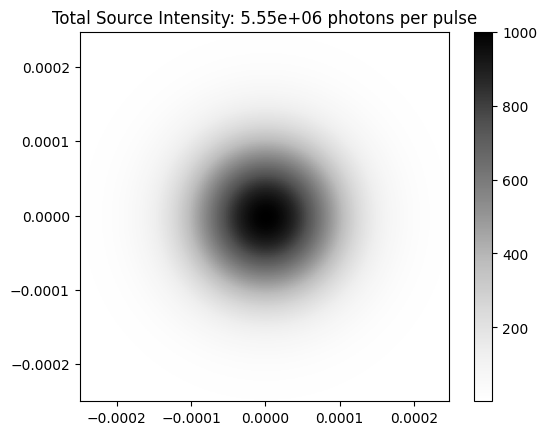

C:\Users\joaooo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_arraypad_impl.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  padded[left_slice] = value_pair[0]
C:\Users\joaooo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_arraypad_impl.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  padded[right_slice] = value_pair[1]


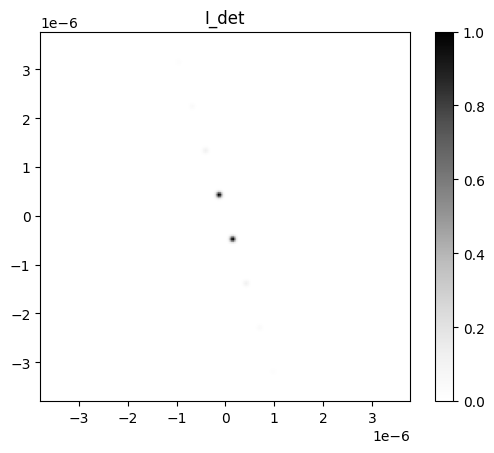

Completed Shot 1/100 - Photons per pixel: 0.00
Completed Shot 2/100 - Photons per pixel: 0.00
Completed Shot 3/100 - Photons per pixel: 0.00
Completed Shot 4/100 - Photons per pixel: 0.00
Completed Shot 5/100 - Photons per pixel: 0.00
Completed Shot 6/100 - Photons per pixel: 0.00
Completed Shot 7/100 - Photons per pixel: 0.00
Completed Shot 8/100 - Photons per pixel: 0.00
Completed Shot 9/100 - Photons per pixel: 0.00
Completed Shot 10/100 - Photons per pixel: 0.00
Completed Shot 11/100 - Photons per pixel: 0.00
Completed Shot 12/100 - Photons per pixel: 0.00
Completed Shot 13/100 - Photons per pixel: 0.00
Completed Shot 14/100 - Photons per pixel: 0.00
Completed Shot 15/100 - Photons per pixel: 0.00
Completed Shot 16/100 - Photons per pixel: 0.00
Completed Shot 17/100 - Photons per pixel: 0.00
Completed Shot 18/100 - Photons per pixel: 0.00
Completed Shot 19/100 - Photons per pixel: 0.00
Completed Shot 20/100 - Photons per pixel: 0.00
Completed Shot 21/100 - Photons per pixel: 0.00
C

In [10]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, setup.num_shots, setup.num_modes_per_shot, setup.I0, setup.z_prop, 
                                                          setup.gauss_width, setup.stripe_period,
                                                          current_object_mask_func,
                                                          setup.num_pixels, dx_source, setup.angle, setup.wavelength,
                                                          bin_factor, setup.gain, setup.QE, setup.ADC_bits, setup.padding_factor)

In [11]:
field_images = np.abs(field_images)**2

In [12]:
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(field_images)

In [13]:
import matplotlib.colors as mcolors

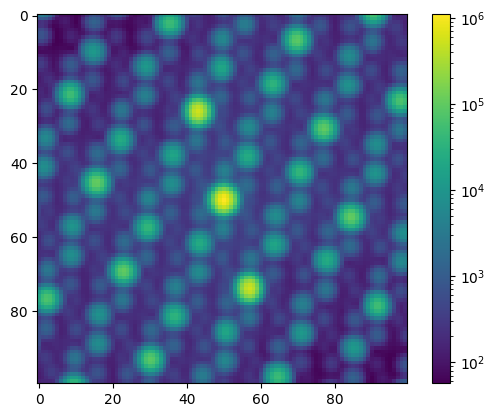

In [14]:
plt.figure()
plt.imshow(autocorr_avg, norm=mcolors.LogNorm())
plt.colorbar()
plt.show()

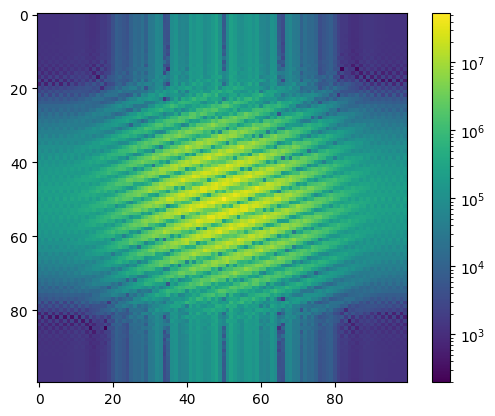

In [15]:
plt.figure()
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(autocorr_avg))), norm=mcolors.LogNorm())
plt.colorbar()
plt.show()

## Custom

In [39]:
# initializing variables
setup = inp.Config('inp_files/setup_2.inp')
setup.padding_factor = int(setup.padding_factor)

In [40]:
def create_slit_pattern_rand_smooth(X, Y, period=4e-6, duty_cycle=0.5, angle=0, smoothing_fraction=0.1, dx_source=1e-6):
    """
    Create a slit pattern with soft edges using a Gaussian blur, where the blur width is a fraction of the period.

    Parameters:
      X, Y               : 2D coordinate grids (meters).
      period             : Period of the slits (meters).
      duty_cycle         : Fraction of each period that is open (transparent).
      angle              : Rotation angle (degrees) of the slit pattern.
      smoothing_fraction : Fraction of the period over which smoothing occurs (e.g., 0.1 for 10%).
      dx_source          : Grid spacing (pixel size in meters).

    Returns:
      pattern_smooth     : 2D **smoothed** array (values between 0 and 1).
    """
    
    # Compute rotated coordinate system
    angle = np.deg2rad(angle)
    xp = X * np.cos(angle) + Y * np.sin(angle)
    
    # Generate a **random phase shift** between 0 and 1 full period
    shift_amount = np.random.uniform(0, period)  
    xp_shifted = xp + shift_amount  # Apply random shift
    
    # Create binary slit pattern
    mod_val = np.mod(xp_shifted, period)
    pattern_hard = np.where(mod_val < duty_cycle * period, 0, 1)
    
    # Define blur width as a fraction of the period
    blur_width = smoothing_fraction * period  # Defines blur in meters
    
    # Convert to pixels
    blur_sigma = blur_width / dx_source  # Converts to pixels
    
    # Apply Gaussian blur for smooth edges
    pattern_smooth = gaussian_filter(pattern_hard.astype(np.complex128), sigma=blur_sigma)
    pattern_smooth = np.clip(pattern_smooth, 0, 1)  # Clip values to [0, 1] to avoid numerical phase shifts
    
    return pattern_smooth

In [41]:
dx_source = setup.grid_size/setup.num_pixels
x_det_sim = np.fft.fftshift(np.fft.fftfreq(setup.num_pixels * (setup.padding_factor-1)//2, d=dx_source))*setup.wavelength*setup.z_prop
dx_det_sim = x_det_sim[1]-x_det_sim[0]
#print(dx_source)
print(x_det_sim)
#dx_det_sim = dx_source #(setup.wavelength*setup.z_prop)/(setup.num_pixels*dx_source)
bin_factor = int(round(setup.detector_pixel_size/dx_det_sim))

#auxiliary variables
source_size=dx_source*setup.num_pixels
x_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
y_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
X_source, Y_source = np.meshgrid(x_source, y_source)

print(dx_source)

[-1.92494853e-04 -1.89664046e-04 -1.86833240e-04 -1.84002433e-04
 -1.81171626e-04 -1.78340820e-04 -1.75510013e-04 -1.72679206e-04
 -1.69848400e-04 -1.67017593e-04 -1.64186786e-04 -1.61355980e-04
 -1.58525173e-04 -1.55694366e-04 -1.52863560e-04 -1.50032753e-04
 -1.47201946e-04 -1.44371140e-04 -1.41540333e-04 -1.38709526e-04
 -1.35878720e-04 -1.33047913e-04 -1.30217106e-04 -1.27386300e-04
 -1.24555493e-04 -1.21724687e-04 -1.18893880e-04 -1.16063073e-04
 -1.13232267e-04 -1.10401460e-04 -1.07570653e-04 -1.04739847e-04
 -1.01909040e-04 -9.90782332e-05 -9.62474265e-05 -9.34166199e-05
 -9.05858132e-05 -8.77550066e-05 -8.49241999e-05 -8.20933932e-05
 -7.92625866e-05 -7.64317799e-05 -7.36009732e-05 -7.07701666e-05
 -6.79393599e-05 -6.51085532e-05 -6.22777466e-05 -5.94469399e-05
 -5.66161333e-05 -5.37853266e-05 -5.09545199e-05 -4.81237133e-05
 -4.52929066e-05 -4.24620999e-05 -3.96312933e-05 -3.68004866e-05
 -3.39696800e-05 -3.11388733e-05 -2.83080666e-05 -2.54772600e-05
 -2.26464533e-05 -1.98156

In [42]:
# checking for sampling conditions and Fresnel number
print("Checking for Fresnel number...")
print(f"N_f = {setup.gauss_width**2/(setup.wavelength*setup.z_prop)}\n")

print("Sampling conditions?")
print(bool(2*np.abs(x_source[1]-x_source[0]) >= setup.wavelength*setup.z_prop/source_size))

Checking for Fresnel number...
N_f = 2.272727272727273

Sampling conditions?
True


In [43]:
gaussian_mask1 = create_gaussian_mask(X_source, Y_source, w=setup.gauss_width)
extent = [x_source[0], x_source[-1], y_source[0], y_source[-1]]
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, setup.stripe_period, angle=73, dx_source=dx_source)
object_mask1 = gaussian_mask1 * grating_mask1

current_object_mask_func = create_slit_pattern_rand_smooth

In [44]:
def fresnel_propagation(E, wavelength, z, dx, padding_factor=1):
    """
    Propagate an input field E using the Fresnel approximation.
    """
    N = E.shape[0]

    pad_width = N * (padding_factor-1)//2

    padded_E = np.pad(E, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
    padded_N = padded_E.shape[0]

    fx = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    FX, FY = np.meshgrid(fx, fy)

    k = 2 * np.pi / wavelength

    H = np.exp(-1j*k*z)*np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))

    input_spectrum = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_E)))

    output_spectrum = input_spectrum * H

    x_det = fx * wavelength * z
    y_det = fy * wavelength * z

    #output_field = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(output_spectrum)))

    return output_spectrum, x_det, y_det

In [52]:
def simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                              gauss_width, stripe_period,
                              current_object_mask_func,
                              num_pixels, dx_source, angle, wavelength,
                              bin_factor, gain, QE, ADC_bits, padding_factor, incoherent=False):
    """
    Simulate intensity images from a multi-shot experiment.
    
    Parameters:
      X_source, Y_source: 2D coordinate grids in the source plane (m)
      num_shots: number of shots (different grating masks)
      num_modes_per_shot: number of modes per shot (random phase realizations)
      I0: source intensity (photons per pixel at source)
      z_prop: propagation distance (m)
      gauss_width: diameter (or width) of the Gaussian aperture (m)
      stripe_period: period of the grating (m)
      current_object_mask_func: function to generate a grating mask;
          Called as: current_object_mask_func(X, Y, period, duty_cycle, angle, smoothing_fraction, dx_source)
      num_pixels: simulation grid size (assumed square)
      dx_source: pixel size in the source plane (m)
      angle: angle for the grating mask (radians)
      wavelength: wavelength (m)
      bin_factor: binning factor to convert simulation resolution to detector resolution
      gain, QE, ADC_bits: parameters for CCD_detection_binned.
      
    Returns:
      intensity_images: list of binned intensity images (one per shot)
      field_images: list of the last propagated field from each shot (optional)
    """
    
    intensity_images = []
    field_images = []
    
    # Create the Gaussian mask using the provided gauss_width.
    gaussian_mask = create_gaussian_mask(X_source, Y_source, w=gauss_width)
    
    for shot in range(num_shots):
        # Generate a grating mask (one per shot) using the provided stripe_period.
        grating_mask = current_object_mask_func(X_source, Y_source, stripe_period, angle=angle, dx_source=dx_source)

        # Combine with the Gaussian mask to form the overall object mask.
        current_object_mask = gaussian_mask * grating_mask
        
        # Compute intensity per mode.
        intensity_per_mode = I0 * np.ones((num_pixels, num_pixels)) / num_modes_per_shot
        
        # Initialize accumulator for shot's full-resolution intensity.
        shot_intensity = np.zeros((padding_factor*num_pixels-1, padding_factor*num_pixels-1))#(int(1/2*padding_factor*num_pixels), int(1/2*padding_factor*num_pixels)))

        for mode in range(num_modes_per_shot):
            # Generate a new random phase pattern.
            if not incoherent:
              E_source = np.sqrt(intensity_per_mode)# * np.exp(1j * random_phase)
            else:
              random_phase = np.random.uniform(0, 2*np.pi, (num_pixels, num_pixels))
              E_source = np.sqrt(intensity_per_mode) * np.exp(1j * random_phase)
                
            # Apply the object mask.
            E_after_object = E_source * current_object_mask

            if shot == 0 and mode == 0:  # Plot only for the first shot and mode
                # Plot amplitude and phase *after* the random phase is applied
                intensity_to_plot = np.abs(E_after_object**2) * num_modes_per_shot
                extent = [np.min(X_source), np.max(X_source), np.min(X_source), np.max(X_source)]
                plt.figure(figsize=(8, 6))
                plt.imshow(intensity_to_plot, extent=extent, cmap='Greys')
                plt.title(f"Total Source Intensity: {np.sum(intensity_to_plot):.2e} photons per pulse")
                plt.colorbar()
                plt.show()

            # Propagate the field.
            E_det, x_det, y_det = fresnel_propagation(E_after_object, wavelength, z_prop, dx_source, padding_factor=padding_factor)
            I_det = np.abs(E_det)**2
            I_det/=np.max(I_det)
            I_det=I_det#[int(1/4*len(I_det)):int(3/4*len(I_det)), int(1/4*len(I_det)):int(3/4*len(I_det))]

            if shot == 0:
              plt.figure()
              extent = [np.min(x_det)/2, np.max(x_det)/2, np.min(y_det)/2, np.max(y_det)/2]
              plt.imshow(I_det, cmap="Greys", extent=extent)
              plt.title("I_det")
              plt.colorbar()
              plt.show()

            shot_intensity += I_det
        
        # Optionally store the last propagated field.
        field_images.append(E_det)

        # Apply CCD detection (including binning, Poisson noise, etc.)
        shot_intensity_binned = CCD_detection_binned(shot_intensity, bin_factor=bin_factor, gain=gain, QE=QE, ADC_bits=ADC_bits)

        intensity_images.append(shot_intensity_binned/np.max(shot_intensity_binned))
        print(f"Completed Shot {shot+1}/{num_shots} - Photons per pixel: {np.sum(shot_intensity_binned)/((num_pixels/bin_factor)**2):.2f}")
    
    return intensity_images, field_images

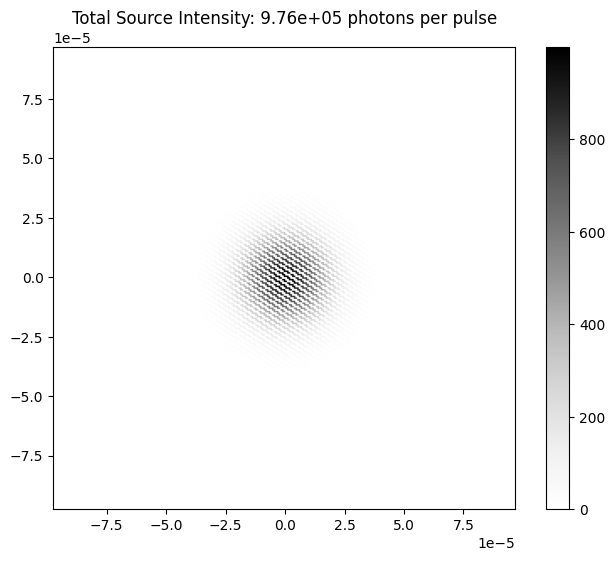

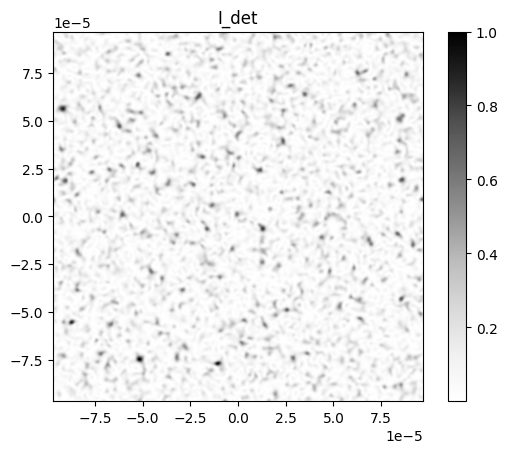

Completed Shot 1/100 - Photons per pixel: 7.33
Completed Shot 2/100 - Photons per pixel: 7.06
Completed Shot 3/100 - Photons per pixel: 7.29
Completed Shot 4/100 - Photons per pixel: 6.37
Completed Shot 5/100 - Photons per pixel: 8.34
Completed Shot 6/100 - Photons per pixel: 6.51
Completed Shot 7/100 - Photons per pixel: 7.41
Completed Shot 8/100 - Photons per pixel: 7.65
Completed Shot 9/100 - Photons per pixel: 7.94
Completed Shot 10/100 - Photons per pixel: 5.24
Completed Shot 11/100 - Photons per pixel: 6.67
Completed Shot 12/100 - Photons per pixel: 7.43
Completed Shot 13/100 - Photons per pixel: 8.30
Completed Shot 14/100 - Photons per pixel: 8.20
Completed Shot 15/100 - Photons per pixel: 8.37
Completed Shot 16/100 - Photons per pixel: 6.46
Completed Shot 17/100 - Photons per pixel: 8.45
Completed Shot 18/100 - Photons per pixel: 7.53
Completed Shot 19/100 - Photons per pixel: 8.00
Completed Shot 20/100 - Photons per pixel: 6.52
Completed Shot 21/100 - Photons per pixel: 6.93
C

In [ ]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, setup.num_shots, setup.num_modes_per_shot, setup.I0, setup.z_prop, 
                                                          setup.gauss_width, setup.stripe_period,
                                                          current_object_mask_func,
                                                          setup.num_pixels, dx_source, setup.angle, setup.wavelength,
                                                          bin_factor, setup.gain, setup.QE, setup.ADC_bits, setup.padding_factor, incoherent=True)

In [ ]:
from scipy.signal import fftconvolve, correlate2d

def compute_g2(intensity_images):
    """
    Compute the ensemble-averaged intensity, autocorrelation (g² proxy),
    and vertical lineout from a list of intensity images.
    
    Returns:
      avg_intensity: ensemble-averaged intensity image
      autocorr_avg: averaged autocorrelation of intensity fluctuations
      vertical_sum: vertical lineout (summed along rows) of autocorr_avg
      I_per_pix: average number of photons per pixel (scalar)
    """
    num_shots = len(intensity_images)
    avg_intensity = np.mean(intensity_images, axis=0)
    deltaI_images = [img - avg_intensity for img in intensity_images]
    N_bin = avg_intensity.shape[0]
    autocorr_sum = np.zeros((N_bin, N_bin))
    for I in intensity_images:
        autocorr = correlate2d(I, I, mode='same').astype(float)
        autocorr /= np.mean(I) ** 2
        autocorr_sum += autocorr
    autocorr_avg = autocorr_sum / num_shots
    I_per_pix = np.mean(avg_intensity)
    vertical_sum = np.sum(autocorr_avg, axis=0)
    return avg_intensity, autocorr_avg, vertical_sum, I_per_pix

In [ ]:
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(intensity_images)

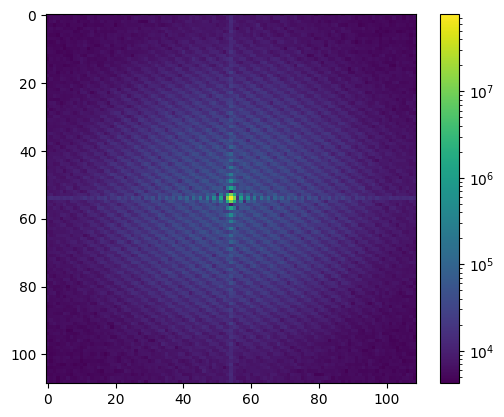

In [ ]:
plt.figure()
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(autocorr_avg))), norm=mcolors.LogNorm())
plt.colorbar()
plt.show()

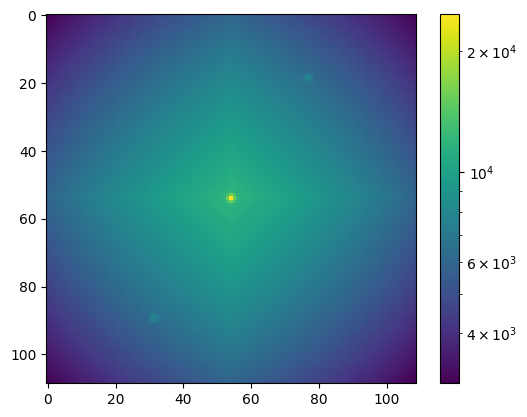

In [ ]:
plt.figure()
plt.imshow(autocorr_avg, norm=mcolors.LogNorm())
plt.colorbar()
plt.show()